<a href="https://colab.research.google.com/github/RonakMehta21/Advanced-Deep-Learning/blob/master/Assignment4/Simple_Meta_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reptile: A Scalable Meta-Learning Algorithm

A minimal example of few-shot regression, predicting a random sine wave from 10 (x,y) pairs. 

This notebook is inspired from [OpenAI's Reptile algorithm](https://arxiv.org/pdf/1803.02999.pdf). 

In [2]:
#Import necessary libraries
import numpy as np
import torch
from torch import nn, autograd as ag
import matplotlib.pyplot as plt
from copy import deepcopy

In [3]:
seed = 0
plot = True
innerstepsize = 0.02 # stepsize in inner SGD
innerepochs = 1 # number of epochs of each inner SGD
outerstepsize0 = 0.1 # stepsize of outer optimization, i.e., meta-optimization
niterations = 30000 # number of outer updates; each iteration we sample one task and update on it

rng = np.random.RandomState(seed)
torch.manual_seed(seed)

Define task distribution

In [4]:
x_all = np.linspace(-5, 5, 50)[:,None] # All of the x points
ntrain = 10 # Size of training minibatches
def gen_task():
    "Generate classification problem"
    phase = rng.uniform(low=0, high=2*np.pi)
    ampl = rng.uniform(0.1, 5)
    f_randomsine = lambda x : np.sin(x + phase) * ampl
    return f_randomsine

Define the model. Reptile paper uses ReLU, but Tanh gives slightly better results

In [5]:
model = nn.Sequential(
    nn.Linear(1, 64),
    nn.Tanh(),
    nn.Linear(64, 64),
    nn.Tanh(),
    nn.Linear(64, 1),
)

def totorch(x):
    return ag.Variable(torch.Tensor(x))

def train_on_batch(x, y):
    x = totorch(x)
    y = totorch(y)
    model.zero_grad()
    ypred = model(x)
    loss = (ypred - y).pow(2).mean()
    loss.backward()
    for param in model.parameters():
        param.data -= innerstepsize * param.grad.data

def predict(x):
    x = totorch(x)
    return model(x).data.numpy()

# Choose a fixed task and minibatch for visualization
f_plot = gen_task()
xtrain_plot = x_all[rng.choice(len(x_all), size=ntrain)]

Reptile training loop

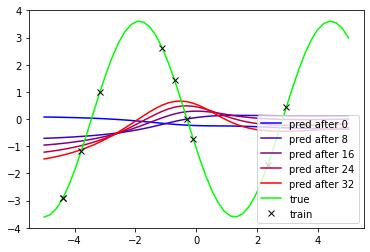

-----------------------------
iteration               1
loss on plotted curve   6.585


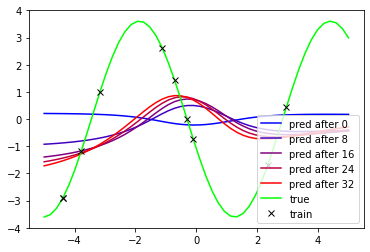

-----------------------------
iteration               1000
loss on plotted curve   6.240


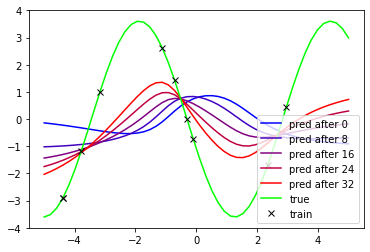

-----------------------------
iteration               2000
loss on plotted curve   3.570


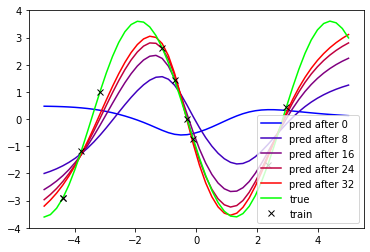

-----------------------------
iteration               3000
loss on plotted curve   0.341


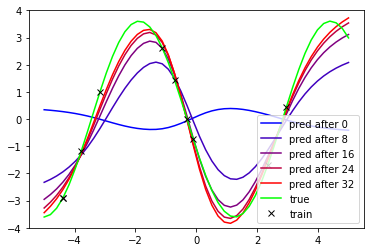

-----------------------------
iteration               4000
loss on plotted curve   0.149


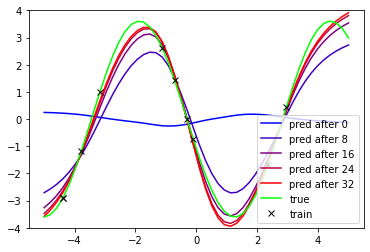

-----------------------------
iteration               5000
loss on plotted curve   0.101


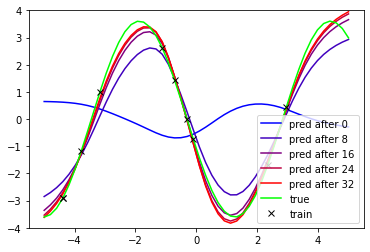

-----------------------------
iteration               6000
loss on plotted curve   0.074


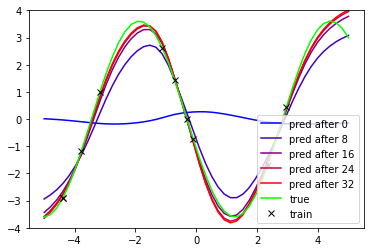

-----------------------------
iteration               7000
loss on plotted curve   0.061


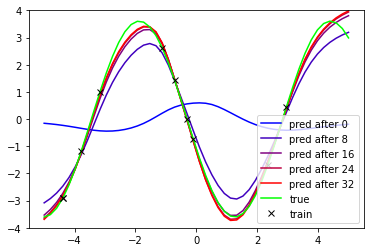

-----------------------------
iteration               8000
loss on plotted curve   0.050


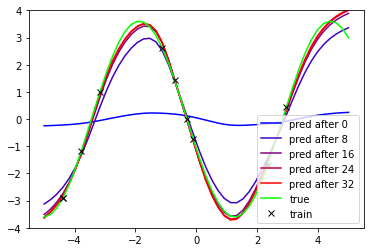

-----------------------------
iteration               9000
loss on plotted curve   0.048


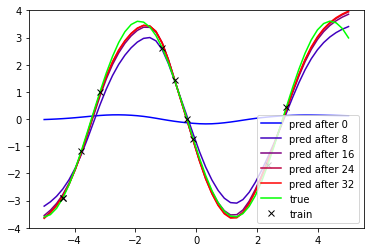

-----------------------------
iteration               10000
loss on plotted curve   0.045


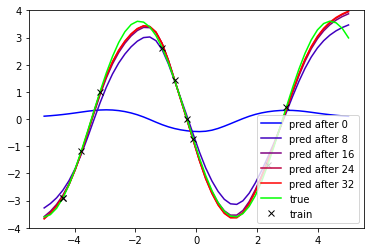

-----------------------------
iteration               11000
loss on plotted curve   0.044


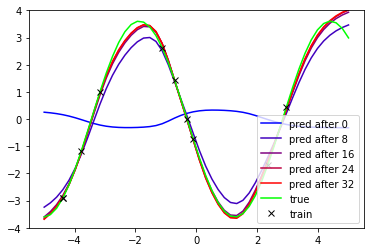

-----------------------------
iteration               12000
loss on plotted curve   0.045


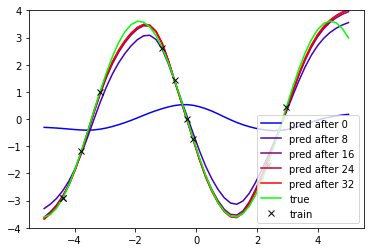

-----------------------------
iteration               13000
loss on plotted curve   0.045


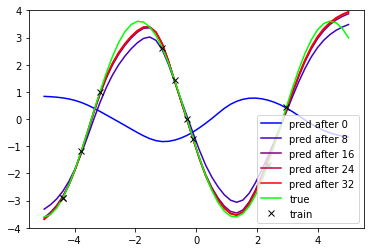

-----------------------------
iteration               14000
loss on plotted curve   0.048


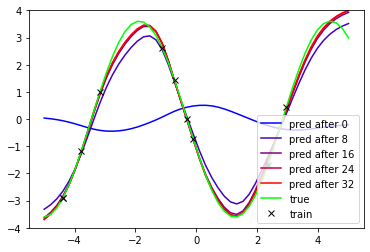

-----------------------------
iteration               15000
loss on plotted curve   0.048


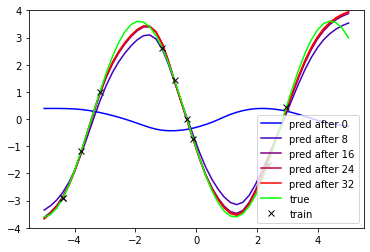

-----------------------------
iteration               16000
loss on plotted curve   0.047


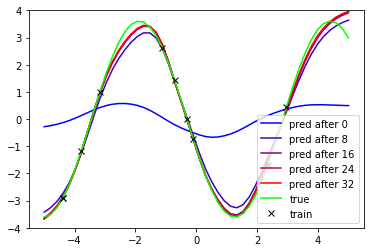

-----------------------------
iteration               17000
loss on plotted curve   0.043


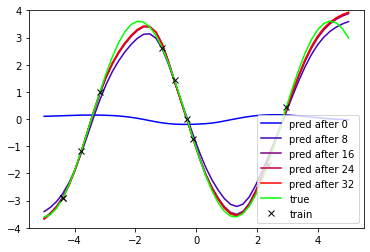

-----------------------------
iteration               18000
loss on plotted curve   0.044


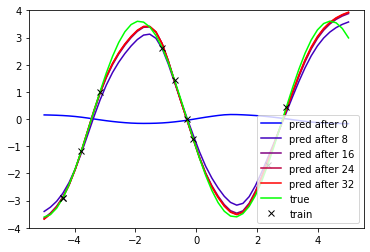

-----------------------------
iteration               19000
loss on plotted curve   0.049


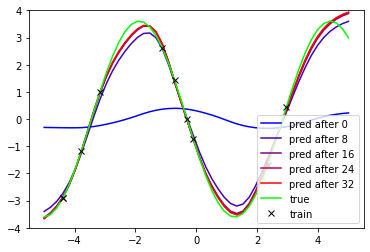

-----------------------------
iteration               20000
loss on plotted curve   0.046


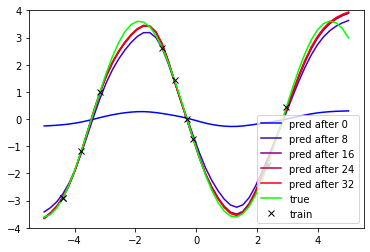

-----------------------------
iteration               21000
loss on plotted curve   0.044


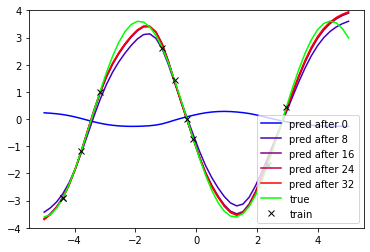

-----------------------------
iteration               22000
loss on plotted curve   0.050


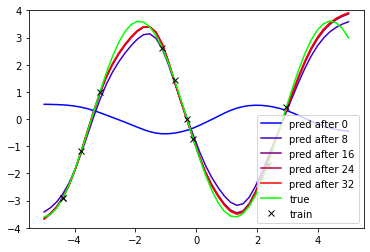

-----------------------------
iteration               23000
loss on plotted curve   0.051


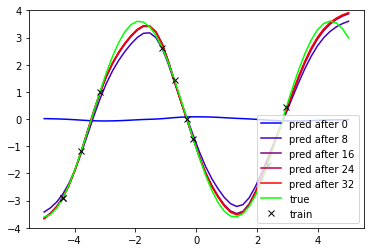

-----------------------------
iteration               24000
loss on plotted curve   0.047


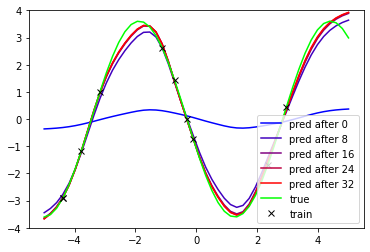

-----------------------------
iteration               25000
loss on plotted curve   0.047


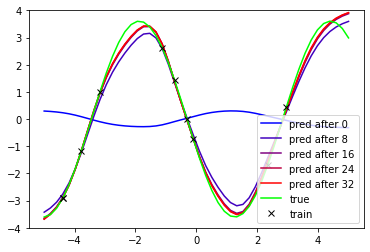

-----------------------------
iteration               26000
loss on plotted curve   0.050


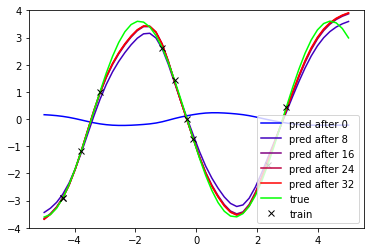

-----------------------------
iteration               27000
loss on plotted curve   0.048


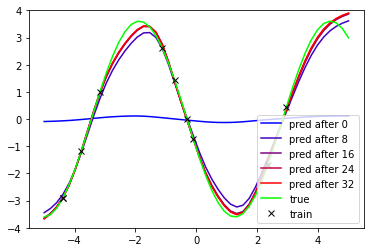

-----------------------------
iteration               28000
loss on plotted curve   0.047


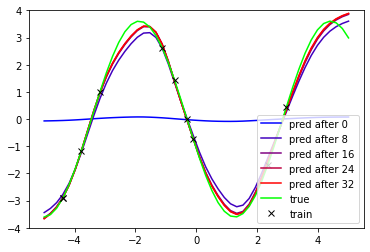

-----------------------------
iteration               29000
loss on plotted curve   0.048


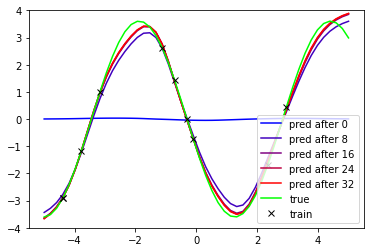

-----------------------------
iteration               30000
loss on plotted curve   0.048


In [6]:
for iteration in range(niterations):
    weights_before = deepcopy(model.state_dict())
    # Generate task
    f = gen_task()
    y_all = f(x_all)
    # Do SGD on this task
    inds = rng.permutation(len(x_all))
    for _ in range(innerepochs):
        for start in range(0, len(x_all), ntrain):
            mbinds = inds[start:start+ntrain]
            train_on_batch(x_all[mbinds], y_all[mbinds])
    # Interpolate between current weights and trained weights from this task
    # I.e. (weights_before - weights_after) is the meta-gradient
    weights_after = model.state_dict()
    outerstepsize = outerstepsize0 * (1 - iteration / niterations) # linear schedule
    model.load_state_dict({name : 
        weights_before[name] + (weights_after[name] - weights_before[name]) * outerstepsize 
        for name in weights_before})

    # Periodically plot the results on a particular task and minibatch
    if plot and iteration==0 or (iteration+1) % 1000 == 0:
        plt.cla()
        f = f_plot
        weights_before = deepcopy(model.state_dict()) # save snapshot before evaluation
        plt.plot(x_all, predict(x_all), label="pred after 0", color=(0,0,1))
        for inneriter in range(32):
            train_on_batch(xtrain_plot, f(xtrain_plot))
            if (inneriter+1) % 8 == 0:
                frac = (inneriter+1) / 32
                plt.plot(x_all, predict(x_all), label="pred after %i"%(inneriter+1), color=(frac, 0, 1-frac))
        plt.plot(x_all, f(x_all), label="true", color=(0,1,0))
        lossval = np.square(predict(x_all) - f(x_all)).mean()
        plt.plot(xtrain_plot, f(xtrain_plot), "x", label="train", color="k")
        plt.ylim(-4,4)
        plt.legend(loc="lower right")
        plt.pause(0.01)
        model.load_state_dict(weights_before) # restore from snapshot
        print(f"-----------------------------")
        print(f"iteration               {iteration+1}")
        print(f"loss on plotted curve   {lossval:.3f}") # would be better to average loss over a set of examples, but this is optimized for brevity